# Trial for ConvLSTM

In [1]:
#Reference 3: Monsoor, Tonmoy, et al. "CNN with data preprocessing.ipynb." BruinLearn, https://bruinlearn.ucla.edu/courses/154235/files/12794459/download?download_frd=1

## import package

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout, ConvLSTM2D
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape,Conv2D, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Bidirectional
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import layers
import time
from sklearn.model_selection import KFold, StratifiedKFold
import pickle
np.random.seed(12345)

## load and visualize data

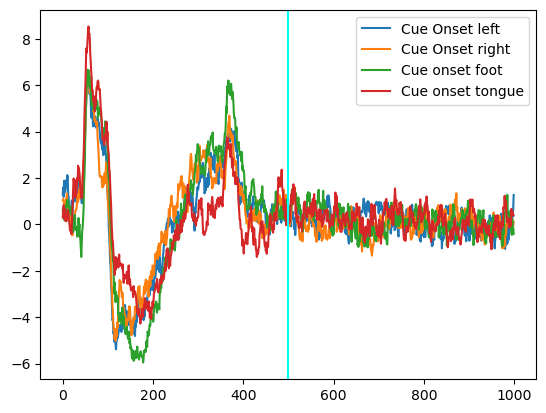

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("/kaggle/input/eeg-247-project/X_test.npy")
y_test = np.load("/kaggle/input/eeg-247-project/y_test.npy")
person_train_valid = np.load("/kaggle/input/eeg-247-project/person_train_valid.npy")
X_train_valid = np.load("/kaggle/input/eeg-247-project/X_train_valid.npy")
y_train_valid = np.load("/kaggle/input/eeg-247-project/y_train_valid.npy")
person_test = np.load("/kaggle/input/eeg-247-project/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

## data preprocessing

In [3]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    return total_X,total_y

In [5]:
x_train_valid_p, y_train_valid_p = data_prep(X_train_valid, y_train_valid, 2, 2, True)
y_train_valid_p = to_categorical(y_train_valid_p, 4)
x_train_valid_p = x_train_valid_p.reshape(x_train_valid_p.shape[0], x_train_valid_p.shape[1], x_train_valid_p.shape[2], 1)
x_train_valid_p = np.swapaxes(x_train_valid_p, 1,3)
x_train_valid_p = np.swapaxes(x_train_valid_p, 1,2)
x_train_valid_p_lstm = x_train_valid_p.reshape((x_train_valid_p.shape[0],1,1,x_train_valid_p.shape[1], x_train_valid_p.shape[3]))

#n_steps, n_length, n_features = 10, 25, 22
#x_train_valid_p_lstm = x_train_valid_p_lstm.reshape((x_train_valid_p_lstm.shape[0], n_steps, 1, n_length, n_features))

## define the architecture of Conv LSTM

In [4]:

def ConvLSTM():
  # Building the CNN model using sequential class
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(1, 1, 250, 22), return_sequences = True))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', return_sequences = True))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(4, activation='softmax'))

  return model

In [6]:
np.shape(x_train_valid_p_lstm)

(8460, 1, 1, 250, 22)

## train and test

In [7]:
hybrid_cnn_lstm_model = ConvLSTM()
hybrid_cnn_lstm_model.summary()

hybrid_cnn_lstm_optimizer_LSTM = keras.optimizers.Adam(learning_rate=1e-3)
        

# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
          optimizer=hybrid_cnn_lstm_optimizer_LSTM,
          metrics=['accuracy'])
        


hybrid_convlstm_model_results = hybrid_cnn_lstm_model.fit(x_train_valid_p_lstm,
      y_train_valid_p,
      batch_size=128,
      epochs=100,
      verbose=True)
        

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 248, 64)     66304     
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 248, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1, 1, 248, 64)     0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 246, 64)     98560     
                                                                 
 batch_normalization_1 (Batc  (None, 1, 1, 246, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 246, 64)     0

2023-03-17 20:47:19.986639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 24s 90ms/step - loss: 2.1464 - accuracy: 0.3356
Epoch 2/100
67/67 [==============================] - 4s 56ms/step - loss: 1.3003 - accuracy: 0.4405
Epoch 3/100
67/67 [==============================] - 4s 60ms/step - loss: 1.0731 - accuracy: 0.5410
Epoch 4/100
67/67 [==============================] - 4s 56ms/step - loss: 0.9024 - accuracy: 0.6314
Epoch 5/100
67/67 [==============================] - 4s 58ms/step - loss: 0.7126 - accuracy: 0.7122
Epoch 6/100
67/67 [==============================] - 4s 58ms/step - loss: 0.5369 - accuracy: 0.7940
Epoch 7/100
67/67 [==============================] - 4s 56ms/step - loss: 0.4011 - accuracy: 0.8489
Epoch 8/100
67/67 [==============================] - 5s 79ms/step - loss: 0.2787 - accuracy: 0.8983
Epoch 9/100
67/67 [==============================] - 6s 91ms/step - loss: 0.2096 - accuracy: 0.9284
Epoch 10/100
67/67 [==============================] - 5s 74ms/step - loss: 0.1451 - accuracy: 0.9530
Epoch 11/1

In [8]:
#save loss as npy
loss=hybrid_convlstm_model_results.history['loss']
np.save('convlstm_train_loss.npy',loss)

In [9]:
x_test_p, y_test_p = data_prep(X_test,y_test,2,2,True)
y_test_p = to_categorical(y_test_p, 4)
x_test_p = x_test_p.reshape(x_test_p.shape[0], x_test_p.shape[1], x_test_p.shape[2], 1)
x_test_p = np.swapaxes(x_test_p, 1,3)
x_test_p = np.swapaxes(x_test_p, 1,2)
x_test_p_lstm = x_test_p.reshape((x_test_p.shape[0],1,1, x_test_p.shape[1], x_test_p.shape[3]))

#n_steps, n_length, n_features = 10, 25, 22
#x_test_p_lstm = x_test_p_lstm.reshape((x_test_p_lstm.shape[0], n_steps, 1, n_length, n_features))

In [10]:
convlstm_score = hybrid_cnn_lstm_model.evaluate(x_test_p_lstm, y_test_p, verbose=0)
print('Test accuracy of ConvLSTM model:', convlstm_score[1])

Test accuracy of ConvLSTM model: 0.490970641374588


## visualize results

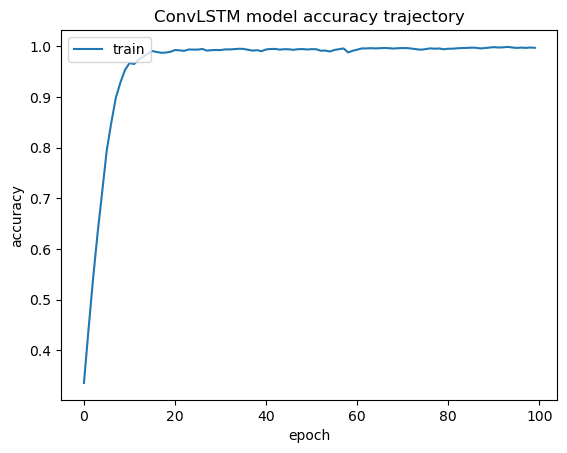

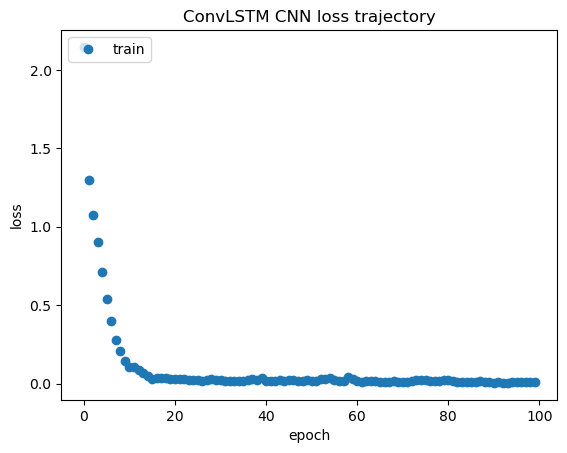

In [11]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_convlstm_model_results.history['accuracy'])
#plt.plot(hybrid_convlstm_model_results.history['val_accuracy'])
plt.title('ConvLSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_convlstm_model_results.history['loss'],'o')
#plt.plot(hybrid_convlstm_model_results.history['val_loss'],'o')
plt.title('ConvLSTM CNN loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()